# ECE1513 practical session 9

### Learning outcomes:
    1. Implementing a simple MLP in PyTorch
    2. Training and testing
    3. Idea of Generalization

### MLP in PyTorch

A Multi-Layer Perceptron (MLP) is a type of neural network composed of multiple layers of neurons. It consists of an input layer, one or more hidden layers, and an output layer. MLPs use activation functions like ReLU to introduce non-linearity.

For this session, we will train a simple MLP to perform a digit recognition
task. That is, we will use the MNIST dataset of hand-written digits, and train the model to **recognize a small digit, namely a digit that is less than 3**.
This problem is a **binary classification problem** we want to predict which of two classes an input image is a part of.

#### Loading the MNIST Dataset

The MNIST dataset contains handwritten digits (0-9) with 28x28=784 pixels. We will use `torchvision` to download and preprocess the dataset.
Let's show a few digits from the dataset.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Define transformations

transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize image pixels to [-1, 1]
])

In [3]:
# Load training and testing datasets

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)  # Download training set
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)  # Load data in batches

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)  # Download test set
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)  # Load test data in batches

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 492kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.54MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 13.2MB/s]


In [4]:
trainset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [5]:
testset

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [6]:
# Visualizing some images from MNIST

def imshow(img):
    img = img / 2 + 0.5  # Unnormalize image back to original scale
    npimg = img.numpy()  # Convert tensor to NumPy array
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Display image
    plt.show()

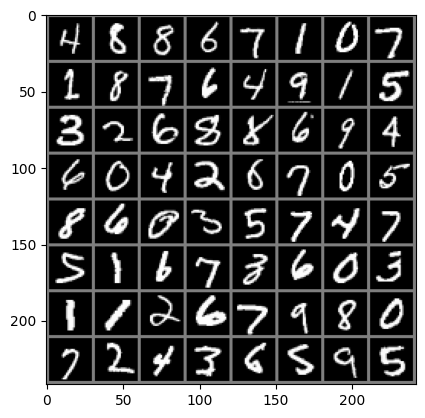

Labels: [4 8 8 6 7 1 0 7 1 8 7 6 4 9 1 5 3 2 6 8 8 6 9 4 6 0 4 2 6 7 0 5 8 6 0 3 5
 7 4 7 5 1 6 7 3 6 0 3 1 1 2 6 7 9 8 0 7 2 4 3 6 5 9 5]


In [7]:
# Get random training images
torch.manual_seed(1) # set the random seed
dataiter = iter(trainloader)  # Create an iterator for the data loader
images, labels = next(dataiter)  # Get the next batch of images and labels

# Show images
imshow(torchvision.utils.make_grid(images))  # Display grid of images
print('Labels:', labels.numpy())  # Print corresponding labels

#### Defining an MLP Model Forward Pass

Now, let's define a simple MLP model with one hidden layer.

In [8]:
torch.manual_seed(1)

class MLP(nn.Module):  # Inherit from nn.Module to define a model
    def __init__(self):
        super(MLP, self).__init__()  # Call parent class constructor
        self.fc1 = nn.Linear(28*28, 30)  # First layer (input to hidden), 784 = 28x28 every pixel is a feature
        self.fc2 = nn.Linear(30, 1)  # Output layer

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten the image into a vector
        x = self.fc1(x)  # Apply first fully connected layer
        x = F.relu(x)  # Apply ReLU activation
        x = self.fc2(x)  # Apply output layer
        return x


# Initialize model
model = MLP()

In this network, there are 28x28 = 784 input neurons, to work with our 28x28 pixel images. We have a single output neuron and a hidden layer of 30 neurons.

The variable `model.fc1` contains information about the connectivity between the input layer and the hidden layer (stored as a matrix), and the biases (stored as a vector).

Similarly, the variable `model.fc2` contains information about the weights between the hidden layer and the output layer, and the bias.

The weights and biases adjust during training, so they are called the model's **parameters**.

In [9]:
# View parameters
for w in model.fc1.parameters():
    print(w)

Parameter containing:
tensor([[ 0.0184, -0.0158, -0.0069,  ...,  0.0068, -0.0041,  0.0025],
        [-0.0274, -0.0224, -0.0309,  ..., -0.0029,  0.0013, -0.0167],
        [ 0.0282, -0.0095, -0.0340,  ..., -0.0141,  0.0056, -0.0335],
        ...,
        [ 0.0267,  0.0186, -0.0326,  ...,  0.0047, -0.0072, -0.0301],
        [-0.0190,  0.0291,  0.0221,  ...,  0.0067,  0.0206,  0.0151],
        [ 0.0226,  0.0331,  0.0182,  ...,  0.0150,  0.0278, -0.0073]],
       requires_grad=True)
Parameter containing:
tensor([-0.0210,  0.0144,  0.0214, -0.0018, -0.0185,  0.0275, -0.0284, -0.0248,
        -0.0180, -0.0168, -0.0226, -0.0093,  0.0211, -0.0311,  0.0002, -0.0010,
         0.0201,  0.0176, -0.0050,  0.0118, -0.0089,  0.0078, -0.0072,  0.0118,
         0.0122, -0.0125,  0.0326,  0.0306,  0.0058, -0.0089],
       requires_grad=True)


#### Test Network Forward Pass

Here is an example of using the network to classify whether the
image contains a small digit.

In [10]:
# Make predictions for the next batch of images

torch.manual_seed(1)
images, labels = next(iter(trainloader)) # Get a batch of images and labels
outputs = model(images)  # Forward pass: find the output given input
probs = torch.sigmoid(outputs) # Convert the output into a probability

print(images.shape)
print(len(outputs))
print(probs[:10],'\n')
print(labels[:10])

torch.Size([64, 1, 28, 28])
64
tensor([[0.4918],
        [0.4613],
        [0.4687],
        [0.5128],
        [0.5234],
        [0.5165],
        [0.5071],
        [0.4882],
        [0.4798],
        [0.4914]], grad_fn=<SliceBackward0>) 

tensor([4, 8, 8, 6, 7, 1, 0, 7, 1, 8])


Since we haven't trained the network yet, the predicted probability of images containing a small digit is close to half.

The "model" is unsure.

In order for the network to be useful, we need to actually train it, so that the weights are actually meaningful, non-random values.

#### Choosing Loss Function and Optimizer

To update the parameters we will first use the network to make predictions, then compare the predictions
against the ground truth. To compare the predictions against actual values we will compute a classification error using the Cross-Entropy equation.

The classification error, that is how good or bad the prediction was compared to the actual values is more commonly referred to as the **loss** and Cross-Entropy is the **loss function**. The introduction of a loss function makes our problem a **optimization** problem: what set of parameters minimizes the loss across the training examples?

Turning a learning problem into an optimization problem
is actually a very subtle but important step in many machine learning tools, because it allows us to use tools from mathematical optimization. There are **optimizers** that can tune the network parameters for us and the gradient descent algorithm we used in the last tutorial is one example of an optimizer.

For now, we will choose a standard loss function for a binary classification problem: the **binary cross-entropy loss**. We'll also choose a **stochastic gradient descent** optimizer.

In [11]:
# Simplified training code to train `model` on the "small digit recognition" task

# Initialize loss function and optimizer
criterion = nn.BCEWithLogitsLoss() # Define loss function for classification
optimizer = optim.SGD(model.parameters(), lr=0.005) # Use SGD optimizer with learning rate 0.005

#### Training the MLP Model
Training involves feeding input data, calculating loss, and updating weights:

1. Show the network a batch of pictures of digits
2. Check what the network predicts
3. Find the loss function, comparing the network prediction against the ground truth
4. Make a small update to the parameters to try and improve the loss
5. Continue doing this many times

For simplicity, we'll use 1000 images, and show the network each image only once.

In [12]:
for images, labels in trainloader: # Iterate over batches
    # Ground truth: is the digit less than 3?
    targets = (labels < 3).reshape([-1,1]).type(torch.FloatTensor)

    # Model prediction
    outputs = model(images)             # step 1-2

    # Update the parameters based on the loss
    loss = criterion(outputs, targets)  # step 3
    loss.backward()                     # step 4 (compute the updates for each parameter)
    optimizer.step()                    # step 4 (make the updates for each parameter)
    optimizer.zero_grad()               # a clean up step for PyTorch

In [13]:
# Test updated network forward pass
torch.manual_seed(1)
images, labels = next(iter(trainloader)) # Get a batch of images and labels

for i in range(10):
  print(labels[i].numpy(), ' vs ', torch.sigmoid(model(images)).flatten()[i].detach().numpy())

4  vs  0.02650807
8  vs  0.066017896
8  vs  0.01707704
6  vs  0.057089258
7  vs  0.031782303
1  vs  0.9209795
0  vs  0.63190204
7  vs  0.029284336
1  vs  0.81630903
8  vs  0.3111733


Not bad! We will use the probability 50% as the cutoff for making a discrete prediction.

In [14]:
def train_model(model, trainloader, criterion, optimizer, epochs=5):
    for epoch in range(epochs):  # Iterate over epochs
        running_loss = 0.0  # Track loss per epoch

        for images, labels in trainloader:  # Iterate over batches

            targets = (labels < 3).reshape([-1,1]).type(torch.FloatTensor)
            outputs = model(images)  # Forward pass through the model

            loss = criterion(outputs, targets)  # Compute loss
            loss.backward()  # Backpropagation to compute gradients
            optimizer.step()  # Update weights
            optimizer.zero_grad()  # Reset gradients to prevent accumulation
            running_loss += loss.item()  # Accumulate loss

        print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader):.4f}")  # Print loss per epoch


model = MLP()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.005)
train_model(model, trainloader, criterion, optimizer)  # Call training function

Epoch 1, Loss: 0.3418
Epoch 2, Loss: 0.2272
Epoch 3, Loss: 0.2079
Epoch 4, Loss: 0.1921
Epoch 5, Loss: 0.1748


#### Evaluating the Model
After training, we can compute the accuracy on the images we used to train the network. Then, we test the model on unseen data to measure generalization. **Generalization** refers to how well the trained model performs on unseen data.

In [15]:
# Computing the error and accuracy on the training set
error = 0
total = 0

for images, labels in trainloader:
    prob = torch.sigmoid(model(images))
    for i in range(len(labels)):
      if (prob[i].item() < 0.5 and labels[i].item() < 3) or (prob[i].item() >= 0.5 and labels[i].item() >= 3):
        error += 1
      total += images.shape[0]

print("Training Error Rate:", error/total)
print("Training Accuracy:", 1 - error/total)

Training Error Rate: 0.0009270701353694318
Training Accuracy: 0.9990729298646306


The accuracy on the training images is 99.9%, which is really good.

However, this accuracy is not representative of how well the network is doing, because the network was **trained** on the data. The network had a chance to
see the actual answer, and learn from that answer. To get a better sense of the network's predictive accuracy, we should compute accuracy numbers on
a **test set**: a set of images that were not seen in training.

In [16]:
# Computing the error and accuracy on a test set
error = 0
total = 0

for images, labels in testloader:
    prob = torch.sigmoid(model(images))
    for i in range(len(labels)):
      if (prob[i].item() < 0.5 and labels[i].item() < 3) or (prob[i].item() >= 0.5 and labels[i].item() >= 3):
        error += 1
      total += images.shape[0]

print("Test Error Rate:", error/total)
print("Test Accuracy:", 1 - error/total)

Test Error Rate: 0.0008416349619543452
Test Accuracy: 0.9991583650380457
